# Рынок заведений общественного питания Москвы

### Описание данных

Нам доступны открытые данные о различных сетевых и не сетевых объектах общественного питания в Москве.

### План по выполнению проекта:
1. Загрузить данные и изучить общую информацию.
1. Оптимизировать данные для анализа (проверить типы данных, обработать пропуски и дубликаты).
1. Проанализировать рынок общественного питания в Москве.
    1. Общий анализ всех заведений
    1. Анализ топ-10 улиц с самым большим количеством заведений
1. Написать общий вывод.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
import requests
from IPython.display import display
from io import BytesIO
warnings.filterwarnings('ignore')

### Шаг 1. Знакомство с данными 

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')

In [3]:
display(df.sample(5))

,id,object_name,chain,object_type,address,number
10463,185867,Ламбик,нет,кафе,"город Москва, Страстной бульвар, дом 7, строен...",25
5877,26579,Царица Востока,нет,ресторан,"город Москва, Рязанский проспект, дом 24, корп...",168
8005,154087,Eat and talk,нет,ресторан,"город Москва, улица Воздвиженка, дом 4/7, стро...",10
7311,148115,Кафе «Венахи»,нет,ресторан,"город Москва, улица Ленинская Слобода, дом 19,...",98
13498,195769,Шоколадница,да,кафе,"город Москва, Профсоюзная улица, дом 102, стро...",75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Вывод шага 1:**

Первый взгляд на данные сделан:
- явных пропусков в данных нет
- в целом типы данных правильные
- нужно проверить данные на наличие дубликатов

Дополнительно:
- выведем уникальные значения в столбцах `chain` и `object_type`, чтобы отловить возможные ошибки
- проверим столбцы с количеством посадочных мест на неотрицательность
- сделаем названия столбцов более понятными
- заменим значения в столбце `chain` на True и False (приведём к типу `bool`) для удобства

### Шаг 2. Подготовка данных 

- ищем дубликаты

In [5]:
df.duplicated().sum()

0

В явном виде дубликаты не найдены

Приведём названия заведений к нижнему регистру, чтобы исключить часть скрытых дубликатов

In [6]:
df['object_name'] = df['object_name'].str.lower()

Исключим столбец `id` и посмотрим, появятся ли дубли

In [7]:
df_check = df.drop('id', axis = 1)
df_check[df_check.duplicated()]

,object_name,chain,object_type,address,number
2381,комбинат питания мгту им.н.э.баумана,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
3397,буфет «коникс-школьник»,нет,буфет,"город Москва, улица Удальцова, дом 21",100
3481,буфет мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
4431,столовая гбоу города москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
4537,столовая «комбинат питания космос»,нет,столовая,"город Москва, Новозаводская улица, дом 12/11",15
...,...,...,...,...,...
14578,старый баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120
14596,буфет при кинотеатре,нет,буфет,"город Москва, Ореховый бульвар, дом 22А",0
14844,sushi-make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
15173,кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0


Появилось 85 дубликатов, их очень мало, просто удаляем их 

In [8]:
dupl = df_check[df_check.duplicated()].index
df.drop(labels = dupl, inplace = True)

- проверяем уникальные значения

In [9]:
df['chain'].value_counts()

нет    12317
да      2964
Name: chain, dtype: int64

С этим столбцом всё в порядке - только два значения, как и предполагалось

In [10]:
df['object_type'].value_counts()

кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1897
бар                                   855
буфет                                 576
кафетерий                             395
закусочная                            348
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Этот столбец тоже сомнений не вызывает. У нас не появились более мелкие группы из-за опечаток в названии

- проверяем столбец `number` на неотрицательность

In [11]:
df['number'].describe()

count    15281.000000
mean        59.788234
std         74.843042
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Отрицательного количества мест нет, но есть заведения, в которых нельзя присесть. Посмотрим на них детальнее

In [12]:
df[df['number'] == 0].sample(5)

,id,object_name,chain,object_type,address,number
680,153361,донер-кебаб,нет,предприятие быстрого обслуживания,"город Москва, улица Академика Миллионщикова, д...",0
14284,214375,вьет лотос,нет,закусочная,"город Москва, Поречная улица, дом 10",0
15085,210711,my box,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова...",0
12243,191304,кофе с собой и кулинария,нет,кафетерий,"город Москва, Шмитовский проезд, дом 12",0
11382,186109,хотдоги,нет,магазин (отдел кулинарии),"город Москва, Пятницкое шоссе, дом 18",0


Теперь понятно - это закусочные, шаурмичные и отделы кулинарии в магазинах. Это проходные места, в которых действительно часто не бывает сидячих мест

- улучшаем названия столбцов

In [13]:
df.rename({'chain': 'is_chain', 'number': 'seats'}, axis = 1, inplace = True)

- обрабатываем столбец `is_chain`

In [14]:
df['is_chain'] = df['is_chain'].apply(lambda x: 1 if x == 'да' else 0).astype('bool')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 6 columns):
id             15281 non-null int64
object_name    15281 non-null object
is_chain       15281 non-null bool
object_type    15281 non-null object
address        15281 non-null object
seats          15281 non-null int64
dtypes: bool(1), int64(2), object(3)
memory usage: 731.2+ KB


Теперь у нас столбец стал булевого типа. Мне кажется, что с ним удобнее работать, да и памяти таблица теперь занимает меньше!

**Вывод шага 2:**

Были изменён тип данных для столбца `is_chain`, улучшены названия столбцов, удалены дубликаты. Произведена проверка данных на корректность (отсутствие пропусков, отрицательного числа посадочных мест). 

Датасеты предобработаны, можно приступать к анализу.

### Шаг 3. Анализ рынка общепита Москвы

- ### 3.1. Общий анализ 

- Исследуем соотношение видов объектов общественного питания по количеству

In [16]:
cnt_type = df.groupby('object_type').agg({'id': 'nunique'}).sort_values(by = 'id', ascending = False)
display(cnt_type)

,id
object_type,
кафе,6071
столовая,2584
ресторан,2282
предприятие быстрого обслуживания,1897
бар,855
буфет,576
кафетерий,395
закусочная,348
магазин (отдел кулинарии),273


In [17]:
cnt_type.reset_index(inplace = True)
cnt_type['object_type_label'] = cnt_type['object_type'].str.replace(' ', '\n')

In [18]:
#функция для построения столбчатой гистограммы
#на вход подаются данные по которым строим, столбец для оси х, столбец для оси у
#rot - угол поворота подписей оси х, width - ширина графика
def standart_graf(data, x, y, rot, width):
    dims = (width, 6)
    fig, ax = plt.subplots(figsize = dims)
    sns.barplot(data = data, x = x, y = y, color = '#51adcf')
    plt.xticks(rotation = rot)
    ax.spines['top'].set_visible(False) #убираем правую границу графика
    ax.spines['right'].set_visible(False) #убираем левую границу графика
    plt.tight_layout() #включаем подписи графиков в сохраненную картинку
    plt.subplots_adjust(top = 0.95) #добавляем немного места наверх, чтобы не обрезать title

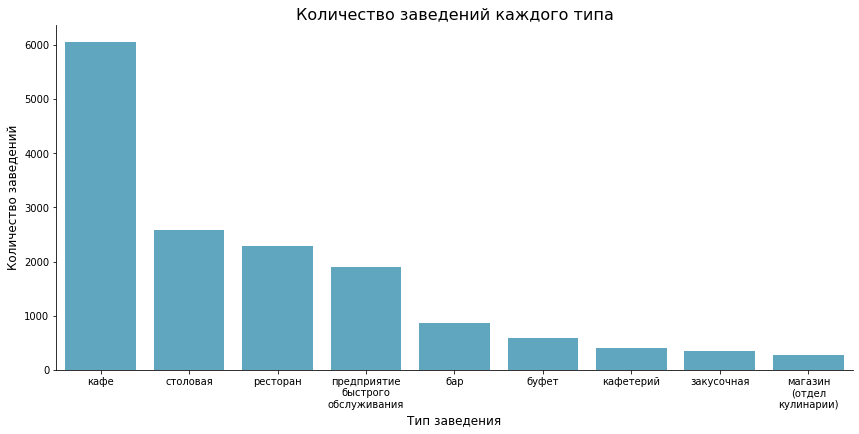

In [19]:
standart_graf(cnt_type, 'object_type_label', 'id', 0, 12)

plt.title('Количество заведений каждого типа', fontsize = 16)
plt.xlabel('Тип заведения', fontsize = 12)
plt.ylabel('Количество заведений', fontsize = 12)


plt.savefig('Количество_заведений_каждого_типа.png')
plt.show()

Больше всего в Москве кафе, столовых и ресторанов. Видимо люди хотят не только подкрепиться, но и посидеть.

- Исследуем соотношение сетевых и несетевых заведений по количеству

In [20]:
amount = df.groupby('is_chain').agg({'id': 'nunique'}).sort_values(by = 'id', ascending = False).reset_index()
amount['is_chain'] = amount['is_chain'].apply(lambda x: 'Несетевые' if x == 0 else 'Сетевые')

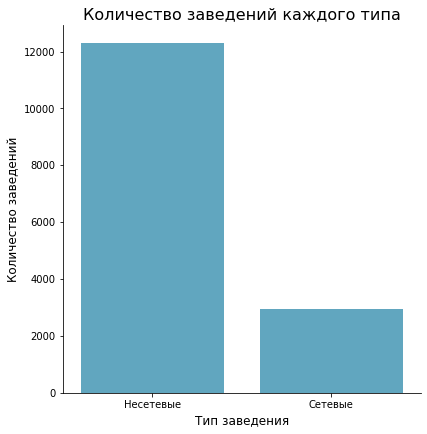

In [21]:
standart_graf(amount, 'is_chain', 'id', 0, 6)

plt.title('Количество заведений каждого типа', fontsize = 16)
plt.xlabel('Тип заведения', fontsize = 12)
plt.ylabel('Количество заведений', fontsize = 12)

plt.savefig('Количество_заведений_сетевых_несетевых.png')
plt.show()

Почти в 4 раза больше несетевых заведений! Скорее всего это из-за того, что содержание нескольких точек требует больших вложений или большой популярности (чтобы открывались франшизы), и владельцам проще направить усилия на развитие 1 заведения.

- Ответим на вопрос: "Для какого вида объекта общественного питания характерно сетевое распространение?"

Посмотрим на процент сетевых заведений для каждого типа.

In [22]:
pivot = df.groupby('object_type').agg({'is_chain': ['sum', 'count']}).reset_index()
pivot['object_type_label'] = pivot['object_type'].str.replace(' ', '\n')
pivot['chain_%'] = (pivot['is_chain']['sum'] / pivot['is_chain']['count']).round(2)
pivot = pivot.sort_values(by = 'chain_%', ascending = False)
pivot[['object_type', 'chain_%']].reset_index(drop = True)

,object_type,chain_%
,,
0,предприятие быстрого обслуживания,0.42
1,магазин (отдел кулинарии),0.29
2,ресторан,0.24
3,кафе,0.23
4,закусочная,0.16
5,кафетерий,0.13
6,бар,0.04
7,буфет,0.02
8,столовая,0.00


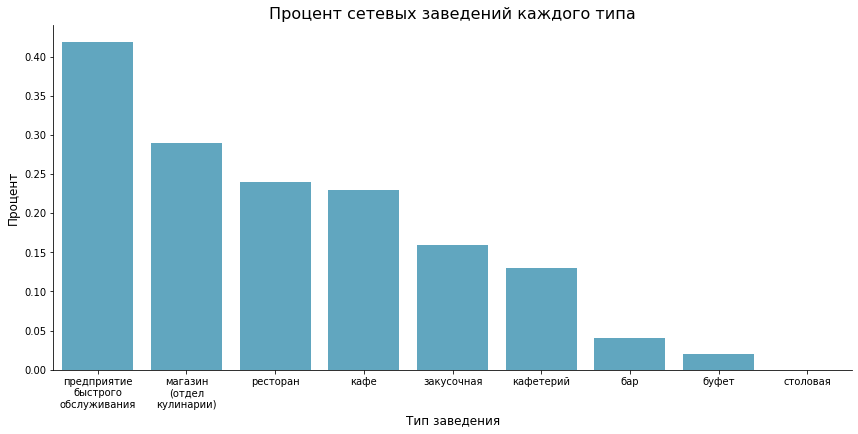

In [23]:
standart_graf(pivot, 'object_type_label', 'chain_%', 0, 12)

plt.title('Процент сетевых заведений каждого типа', fontsize = 16)
plt.xlabel('Тип заведения', fontsize = 12)
plt.ylabel('Процент', fontsize = 12)

plt.savefig('Процент_сетевых_заведений_каждого_типа.png')
plt.show()

Предприятия быстрого обслуживания почти поровну представлены и сетями и одиночными заведениями. На то они и быстрые, что там нет кухни с 10 поварами и 30 официантами. Такие точки можно легко открыть в нескольких местах даже не по франшизе. 

Сетевых столовых почти нет, возможно, они все находятся при каких-то заводах или университетах и обслуживают только конекретных рабочих и студентов. Тогда для владельцев важна ни столько прибыль и расширение сети, сколько качество и удобство клиентов.

- Определим, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест? 

Выберем из основных данных только сетевые заведения, посчитаем количество точек в каждой сети и среднее количество посадочных мест

In [24]:
chain = df[df['is_chain']]
chain_seats = (chain
               .groupby('object_name')
               .agg({'seats': 'sum', 'id': 'count'})
               .sort_values(by = 'id', ascending = False)
              )
chain_seats['seats_mean'] = (chain_seats['seats'] / chain_seats['id']).astype(int)
chain_seats.rename({'id': 'places'}, axis = 1, inplace = True)

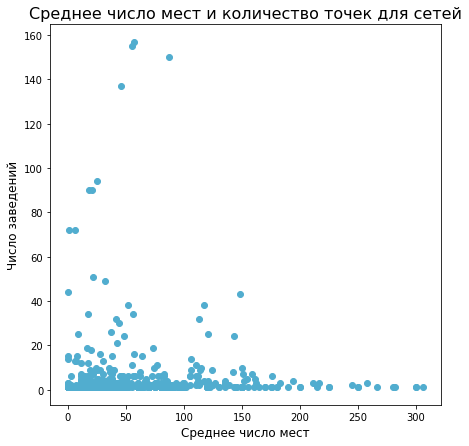

In [25]:
dims = (7, 7)
fig, ax = plt.subplots(figsize = dims)

plt.scatter(x ='seats_mean', y ='places', data = chain_seats, c = '#51adcf')

plt.title('Среднее число мест и количество точек для сетей', fontsize = 16)
plt.xlabel('Среднее число мест', fontsize = 12)
plt.ylabel('Число заведений', fontsize = 12)
plt.show()

Из-за аномальных данных график плохо читается. Отсечём 5% сетей с аномально большим числом заведений

In [26]:
places95 = np.percentile(chain_seats['places'], 95)
clean_chs = chain_seats[chain_seats['places'] <= places95]

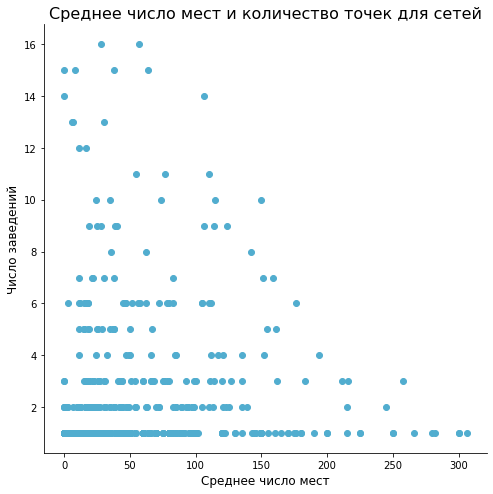

In [27]:
dims = (7, 7)
fig, ax = plt.subplots(figsize = dims)
plt.scatter(x ='seats_mean', y ='places', data = clean_chs, c = '#51adcf')

ax.spines['top'].set_visible(False) #убираем правую границу графика
ax.spines['right'].set_visible(False) #убираем левую границу графика
plt.tight_layout() #включаем подписи графиков в сохраненную картинку
plt.subplots_adjust(top = 0.95, bottom = 0.10, left = 0.10) 

plt.title('Среднее число мест и количество точек для сетей', fontsize = 16)
plt.xlabel('Среднее число мест', fontsize = 12)
plt.ylabel('Число заведений', fontsize = 12)

plt.savefig('Среднее_число_мест_и_количество_точек_для_сетей.png')
plt.show()

Сетевым заведением уже считается заведение с двумя точками и больше. По графику совместного распределения видно, что в сети обычно не больше 6 точек и в каждой из этих точек в среднем от 0 (если это сеть быстрого питания) до 150 мест (если это сеть кафе или ресторанов).

Отвечая на вопрос: для сетевых заведений более характерно мало заведений (2-6) с большим числом (до 150) посадочных мест

- ### 3.2. Топ-10 улиц 

- Выделим в отдельный столбец информацию об улице из столбца address

Посмотрим как записаны адреса

In [28]:
df['address'].sample(5)

5929     город Москва, Рязанский проспект, дом 32, корп...
10742    город Москва, Гостиничный проезд, дом 8, корпус 1
10562        город Москва, улица Адмирала Лазарева, дом 38
9553               город Москва, Кустанайская улица, дом 6
7672                   город Москва, улица Вавилова, дом 3
Name: address, dtype: object

Выделим улицу, как все символы между двумя запятыми до слов дом или владение

In [29]:
df['address'] = df['address'].str.lower()

In [30]:
df['street'] = df['address'].str.extract(', (.*), [дом|владение]')

In [31]:
df.sample(3)

,id,object_name,is_chain,object_type,address,seats,street
13786,217321,кальянная - компьютерный клуб,False,кафе,"город москва, поселение десеновское, 3-я новов...",10,"поселение десеновское, 3-я нововатутинская улица"
3470,28452,столовая бабурова и.н.,False,столовая,"город москва, ленинградский проспект, дом 47, ...",20,ленинградский проспект
13145,199139,«снек бар в кинотеатре «космик»»,False,кафетерий,"город москва, варшавское шоссе, дом 160",6,варшавское шоссе


Проверим данные на пропуски и ошибки

In [32]:
df[df['street'].isna()].head(5)

,id,object_name,is_chain,object_type,address,seats,street
859,23601,буфет - гбоу сош № 64,False,буфет,"партизанская улица, дом 30",100,NaN
860,23604,буфет - гбоу 60,False,буфет,"партизанская улица, дом 30",100,NaN
1405,20199,это,False,кафе,"город москва, город зеленоград, корпус 401",35,NaN
1406,68113,френдс,False,кафе,"город москва, город зеленоград, корпус 435",34,NaN
1407,20105,кафе «граф монте-кристо»,False,кафе,"город москва, город зеленоград, корпус 436",40,NaN


Ага, некоторые адреса сразу начинаются с улицы, поэтому условие не срабатывает. Возьмём тогда все символы до запятой и слов дом/владение

In [33]:
df.loc[df['street'].isna(), 'street'] = df.loc[df['street'].isna(), 'address'].str.extract('(.*), [дом|владение]')[0]

In [34]:
df.loc[df['street'].isna(), 'address'].value_counts()

город москва, город зеленоград, корпус 317а, строение 1    4
город москва, город зеленоград, корпус 2309а               3
город москва, город зеленоград, корпус 124, строение 1     3
город москва, город зеленоград, корпус 1805                3
город москва, город зеленоград, корпус 1543                2
                                                          ..
город москва, город зеленоград, корпус 314                 1
город москва, город зеленоград, корпус 428а                1
город москва, город зеленоград, корпус 126                 1
город москва, город зеленоград, корпус 341а                1
город москва, город зеленоград, корпус 929а                1
Name: address, Length: 109, dtype: int64

Теперь пропуски остались только для 109 заведений Зеленограда. У них нет улицы, так что я думаю, будет проще их удалить.

In [35]:
df.dropna(inplace = True)

Теперь пропусков нет, все улицы найдены

- Найдём топ-10 улиц по количеству объектов общественного питания. И с помощью внешней информации определим в каких районах Москвы находятся эти улицы?

In [36]:
street10 = (df
            .groupby('street')
            .agg({'id': 'nunique'})
            .sort_values(by = 'id', ascending = False)
            .head(10)
            .reset_index()
            .rename({'id': 'foodservices'}, axis = 1)
           )

In [37]:
street10['street_label'] = street10['street'].str.replace(' ', '\n')

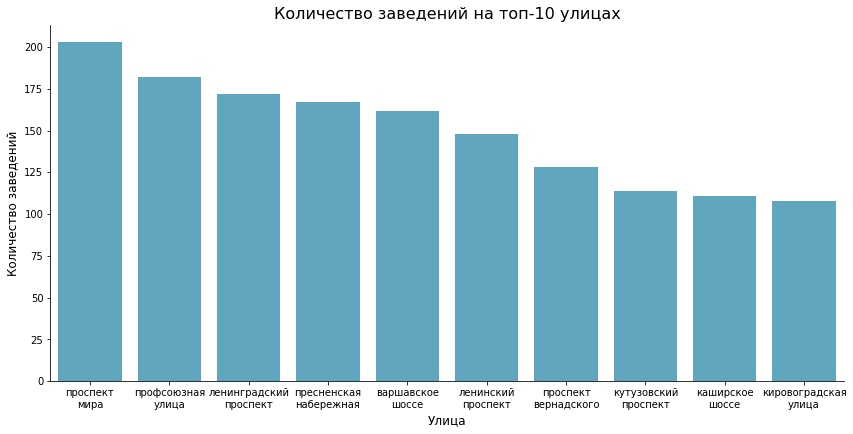

In [38]:
standart_graf(street10, 'street_label', 'foodservices', 0, 12)

plt.title('Количество заведений на топ-10 улицах', fontsize = 16)
plt.xlabel('Улица', fontsize = 12)
plt.ylabel('Количество заведений', fontsize = 12)

plt.savefig('Количество_заведений_на_топ-10_улицах.png')
plt.show()

Добавим файл с районами по адресу

In [39]:
spreadsheet_id = '1wt_EPR9Pnsnhn5V3t62y9XQoL9dPtUXWhffqeGfUc28'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
districts = pd.read_csv(BytesIO(r.content))

In [40]:
districts.sample(3)

,streetname,areaid,okrug,area
348,улица Каретный Ряд,19,ЦАО,Тверской район
3391,улица Маршала Захарова,105,ЮАО,Район Орехово-Борисово Северное
1445,улица Федосьино,42,ЗАО,Район Ново-Переделкино


Приводим данные к нижнему регистру для избежания ошибок при объединении

In [41]:
for column in ['streetname', 'okrug', 'area']:
    districts[column] = districts[column].str.lower()

In [42]:
districts.rename({'streetname': 'street'}, axis = 1, inplace = True)

Некоторым улицам соответствуют сразу несколько районов. Оставим только первый из них

In [43]:
districts.drop_duplicates('street', inplace = True)

In [44]:
street10 = street10.merge(districts, how = 'left', left_on = 'street', right_on = 'street')

In [45]:
street10[['street', 'okrug', 'area']]

,street,okrug,area
0,проспект мира,свао,алексеевский район
1,профсоюзная улица,юзао,академический район
2,ленинградский проспект,сао,район аэропорт
3,пресненская набережная,цао,пресненский район
4,варшавское шоссе,юао,район чертаново центральное
5,ленинский проспект,зао,район проспект вернадского
6,проспект вернадского,зао,район проспект вернадского
7,кутузовский проспект,зао,район дорогомилово
8,каширское шоссе,юао,район москворечье-сабурово
9,кировоградская улица,юао,район чертаново центральное


Все эти улицы достаточно длинные, поэтому на них конечно же будет очень много различных объектов общественного питания. К тому же до них легко добраться на автомобиле

- Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [46]:
only_object = (df
               .groupby('street')
               .agg({'id': 'nunique'})
               .reset_index()
              )
only_object = only_object[only_object['id'] == 1]

In [47]:
print(f'Количество улиц Москвы с одним заведением: {len(only_object)}')

Количество улиц Москвы с одним заведением: 634


In [48]:
only_object = only_object.merge(districts, how = 'left', left_on = 'street', right_on = 'street')

In [49]:
(only_object
            .groupby('area')
            .agg({'street': 'count'})
            .sort_values(by = 'street', ascending = False)
            .rename({'street': 'streets with 1 object'}, axis = 1)
            .head(10)
)

,streets with 1 object
area,
таганский район,27
басманный район,24
район хамовники,22
пресненский район,20
тверской район,20
район марьина роща,17
район сокольники,15
район арбат,14
район замоскворечье,14


Большая часть этих районов находится достаточно близко к центру или к какому-то популярному месту (как район Сокольники). 
Мои предположения: 
1. в этих районах очень много мелких улочек, на которых как раз размещается какой-нибудь один объект
2. в этих районах дорогая аренда, поэтому открываются только очень прибыльные заведения, например, какой-нибудь большой ресторан 

- Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [50]:
top_ids = street10['street']

In [51]:
street10_seats = df[df['street'].isin(top_ids)]

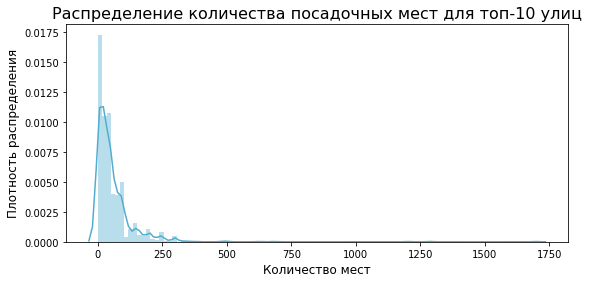

In [52]:
dims = (9, 4)
fig, ax = plt.subplots(figsize = dims)

sns.distplot(street10_seats['seats'], bins=100, color = '#51adcf')
plt.title('Распределение количества посадочных мест для топ-10 улиц', fontsize = 16)
plt.xlabel('Количество мест', fontsize = 12)
plt.ylabel('Плотность распределения', fontsize = 12)
plt.show()

На графике распределения оказался очень длинный хвост из-за аномальных данных. Отсеим 5% выбивающихся заведений

In [53]:
seats95 = np.percentile(street10_seats['seats'], 95)
clean_s10s = street10_seats[street10_seats['seats'] <= seats95]

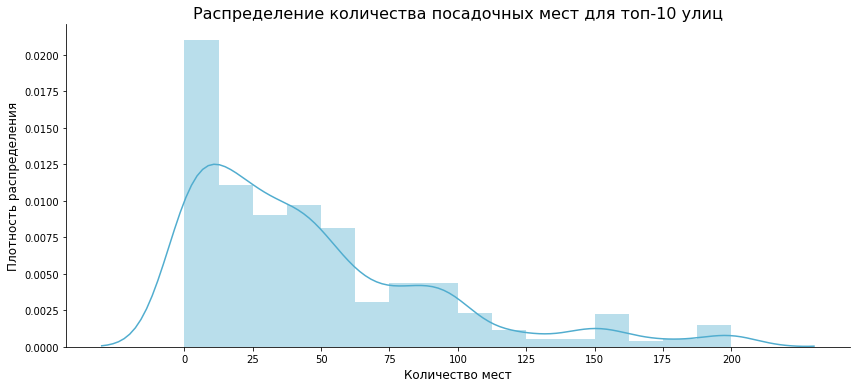

In [54]:
dims = (12, 6)
fig, ax = plt.subplots(figsize = dims)

sns.distplot(clean_s10s['seats'], bins = 16, color = '#51adcf')
plt.title('Распределение количества посадочных мест для топ-10 улиц', fontsize = 16)
plt.xlabel('Количество мест', fontsize = 12)
plt.ylabel('Плотность распределения', fontsize = 12)
plt.xticks(np.arange(0, 225, step = 25))
ax.spines['top'].set_visible(False) #убираем правую границу графика
ax.spines['right'].set_visible(False) #убираем левую границу графика
plt.tight_layout() #включаем подписи графиков в сохраненную картинку
plt.subplots_adjust(top = 0.85) #добавляем немного места наверх, чтобы не обрезать title
plt.savefig('Распределение_количества_мест_для_топ-10_улиц.png')
plt.show()

Это Пуассоновское распределение. Можно сказать, что очень много заведений не может разместить более 10 человек. Может посмотрим на это же распределение по типам объектов?

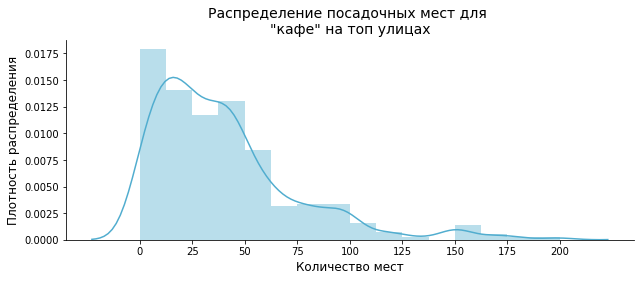

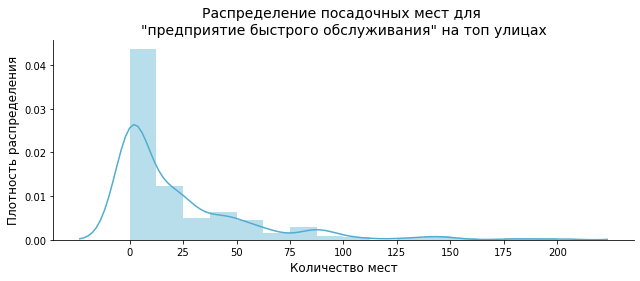

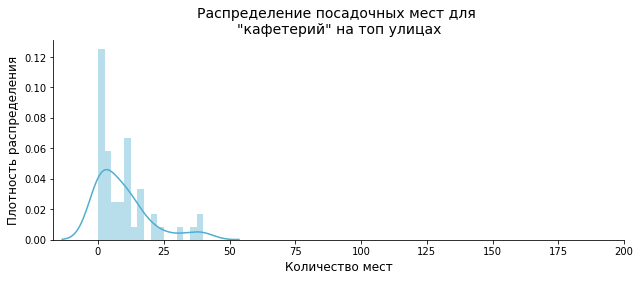

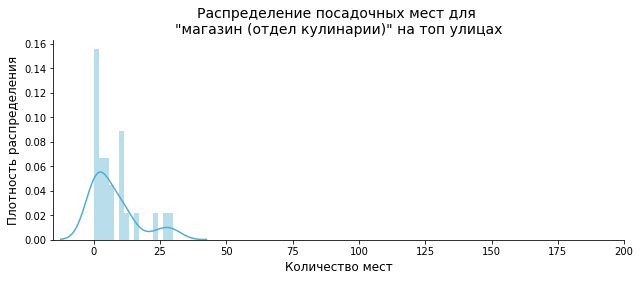

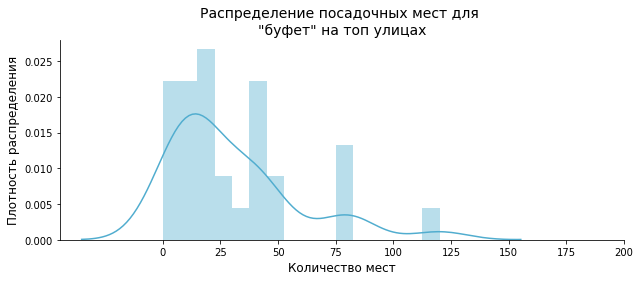

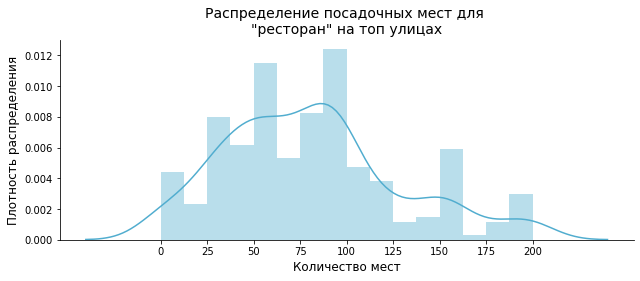

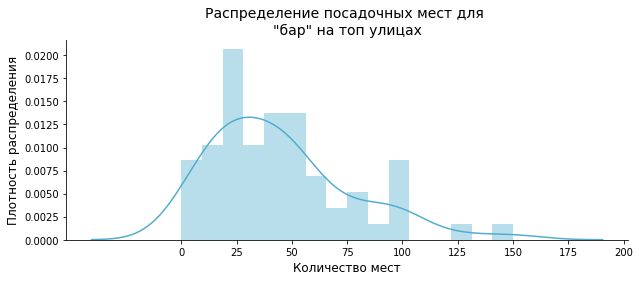

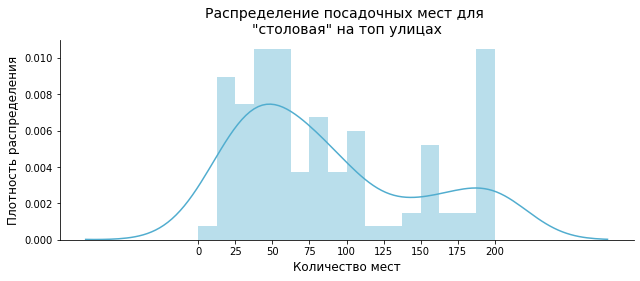

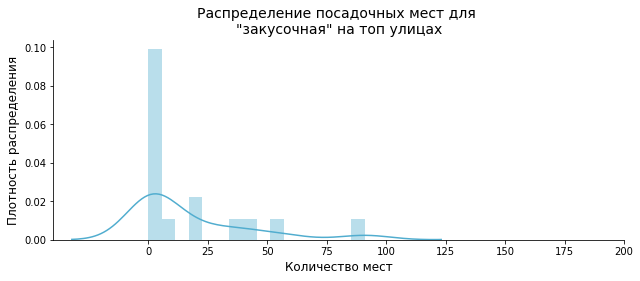

In [55]:
for object_type in clean_s10s['object_type'].unique():
    dims = (9, 4)
    fig, ax = plt.subplots(figsize = dims)
    data = clean_s10s[clean_s10s['object_type'] == object_type]['seats']
    sns.distplot(data, bins = 16, color = '#51adcf')
    plt.title(f'Распределение посадочных мест для \n"{object_type}" на топ улицах', fontsize = 14)
    plt.xlabel('Количество мест', fontsize = 12)
    plt.ylabel('Плотность распределения', fontsize = 12)
    plt.xticks(np.arange(0, 225, step = 25))
    ax.spines['top'].set_visible(False) #убираем правую границу графика
    ax.spines['right'].set_visible(False) #убираем левую границу графика
    plt.tight_layout() #включаем подписи графиков в сохраненную картинку
    plt.subplots_adjust(top = 0.85) #добавляем немного места наверх, чтобы не обрезать title
    plt.savefig(f'{object_type}.png')
    plt.show()

Теперь распределения отличаются от общей картины:
- для кафе, буфета, бара и столовой скорее характерно наличие 20-50 посадочных мест
- для предприятия быстрого обслуживания, кафетерия, отдела кулинарии в магазине и закусочной много мест не нужно: достаточно от 0 до 10 мест
- а распределение для ресторана уже больше похоже на нормальное: 50-100 мест это классика

Выводы не противоречат логике: во вторую группу заведений забегают поесть и долго не задерживаются, в третьей приходят приятно провести весь вечер, а то и день, причем часто большой компанией, а первая группа - это нечто среднее, где можно и посидеть и быстро подкрепиться.

**Вывод шага 3:**

Исходя из полученных выше данных можно сформировать рекомендацию для нового заведения:
- сделать его в формате предприятия быстрого обслуживания: такие объекты часто становятся сетевыми (40% таких заведений - сетевые), простое и небольшое меню упростит задачу настройки роботов-поваров. К тому же люди не будут ожидать подачи еды к столику, поэтому не нужно задумываться о роботах-официантах и выборе их кратчайшего маршрута - всего лишь нужен робот, который будет находиться в зоне выдачи  
- поставить небольшое количества сидячих мест (10-25), так как в таких заведениях большая проходимость и людям важнее быстрый перекус или еда с собой
- начинать в каком-нибудь не центральном районе, около большой улицы. Например, в Алексеевском районе на улице Проспект мира, там и аренда будет недорогая, и людей будет достаточно много

В дальнейшем можно открыть новые точки в других районах, этот тип заведений отлично подходит для сети.

### Шаг 4. Общий вывод 

1. Были проанализированные данные о рынке общественного питания в Москве. 
1. Данные оптимизированы, приведены к нужным типам и проверены на корректность.
1. Проанализирован рынок общественного питания в Москве:

    - Общий анализ рынка
        - больше всего заведений типа кафе
        - несетевых заведений почти в 4 раза больше сетевых
        - для предприятий быстрого обслуживания характерно сетевое распространение
        - определено, что у сетевых заведений мало точек (2-6), и достаточно много мест (от 0 до 150 в зависимости от типа заведения)
    - Анализ улиц и районов    
        - проанализированы 10 улиц с наибольшим количеством объектов общественного питания (широкие улицы, проспекты и шоссе)
        - определены районы, в которых они находятся (нецентральные районы)
        - аналогично определены районы, в которых больше всего улиц лишь с 1 заведением (большинство таких районов оказались центральными, из-за чего можно сделать вывод, что там не очень выгодно открывать заведения)
    
Сделана рекомендация по развитию сети: развивать сеть предприятий быстрого обслуживания с небольшим количеством мест (10-25) и открыть первую точку в Алексеевском районе.